In [1]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math
import numpy as np
from dataclasses import replace
import qutip
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

In [4]:
n_bosons = 3
phase = 0  # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(
    n_bosons=n_bosons,
    phase=phase,
    excitation_level=True,
)
print_model_info(model)

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=True, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Активируем уровни возбудженного состояния и линии связи

In [5]:
ecmodel = replace(model, excitation_level=True, communication_line=True)

Начальное состояние системы: суперпозиция между атомами a и b

In [6]:
init_state = (
    bec.coherent_state_constructor(ecmodel, n=2, k=0)
    * bec.coherent_state_constructor(
        ecmodel, 2, 1, math.sqrt(1 / 10), math.sqrt(9 / 10)
    )
    * bec.vacuum_state(ecmodel, n=2)
)

## Эволюция под действием "низкоуровневого" гамильтониана

Гамильтониан из Alexey2013

In [7]:
h = bec.h_int(ecmodel, true_hc=True)

Гамильтониан из Rosseau2014

In [8]:
h = bec.hamiltonian_coupling(ecmodel) + bec.hamiltonian_laser_field(ecmodel)

In [9]:
tspan, dt = np.linspace(0, 3500, 3501, retstep=True)

t_list = tspan
evolution = qutip.mesolve(
    h,
    init_state,
    t_list,
    progress_bar=TqdmProgressBar(),
)

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3501/3501 [01:08<00:00, 51.03it/s]


### Зависимость энтропии от времени

In [10]:
fidelity_span = [
    qutip.metrics.fidelity(init_state, s) for s in tqdm(evolution.states, ncols=80)
]

100%|████████████████████████████████████| 3501/3501 [00:00<00:00, 48316.99it/s]


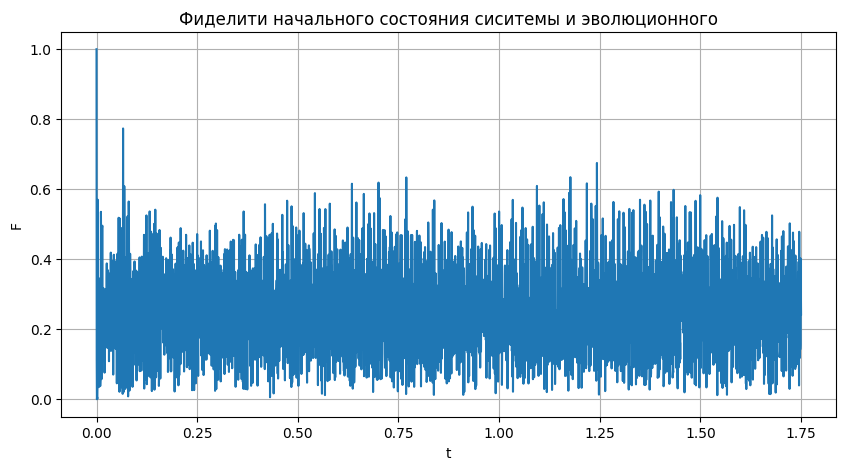

In [11]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan * model.Omega, fidelity_span)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделити начального состояния сиситемы и эволюционного")
ax.grid()

### Зависимость энтропии от времени

In [12]:
evolution_states_reduced_by_second_qubit = [
    qutip.ptrace(s, [0, 1, 2, 3]) for s in tqdm(evolution.states)
]

100%|██████████| 3501/3501 [00:02<00:00, 1699.38it/s]


In [13]:
entropy = [qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in tqdm(evolution.states)]

100%|██████████| 3501/3501 [00:01<00:00, 2593.07it/s]


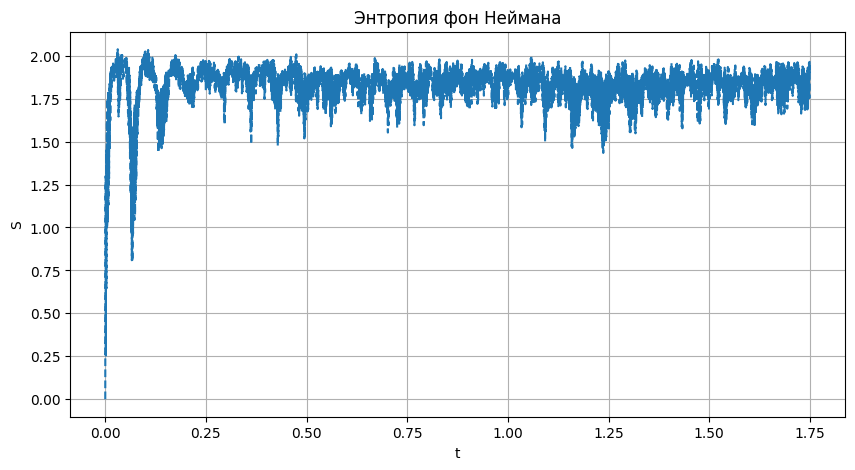

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan * model.Omega, entropy, "--", label="mesolve")

ax.set_ylabel("S")
ax.set_xlabel("t")
ax.set_title("Энтропия фон Неймана")
ax.grid()

# plt.savefig("../entropy_vn-b1.png")

### Негативити

In [15]:
evolution_states_b1_c_b2 = [
    qutip.ptrace(s, [0, 1, 4, 5]) for s in tqdm(evolution.states)
]

100%|██████████| 3501/3501 [00:03<00:00, 878.21it/s]


In [16]:
evolution_states_b1_c_b2_partial_transposed = [
    qutip.partial_transpose(s, [0, 1, 0, 1]) for s in evolution_states_b1_c_b2
]

In [17]:
negativity = [
    np.log2(np.sum(np.abs(s.eigenenergies())))
    for s in tqdm(evolution_states_b1_c_b2_partial_transposed)
]

100%|██████████| 3501/3501 [02:39<00:00, 21.89it/s]


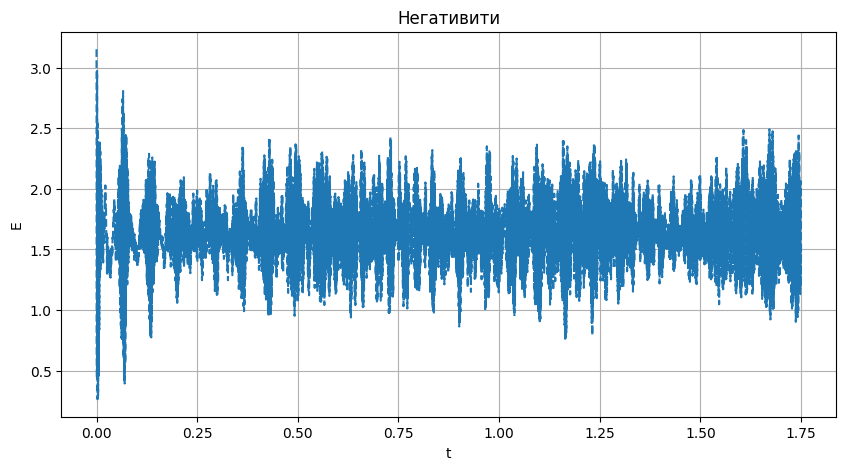

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan * ecmodel.Omega, negativity, "--", label="mesolve")
ax.set_ylabel("E")
ax.set_xlabel("t")
ax.set_title("Негативити")
ax.grid()